This file shows how I gather data by grabbing english pair dataset first and then translating to Georgian. 
I chose to do pairs gahering rather than triplets gathering.   
In this notebook I also show the error that I got along the way to show why I stopped using each approach and switched to another one.

In [6]:
pip install google-auth>=1.24.0

Note: you may need to restart the kernel to use updated packages.


In [21]:
# libraries:
import pandas as pd
import json
import time
import os
import re

from google.cloud import translate
from html import unescape

#commenting out libraries that I stopped using.
#from openai import OpenAI
#import googletrans
#from googletrans import Translator

#display properties:
pd.set_option('display.max_colwidth', None)

note, upon import of translator from googletrans, I got error:  
AttributeError: module 'httpcore' has no attribute 'SyncHTTPTransport'  
after various workarounds, I downgraded openAI as adviced here: https://wikidocs.net/231380  
so you will have to upgrade openAI and uncomment import for it if you need to repeat this code.

In [31]:
#defining useful functions:

#translates sentence to georgian from english through openAI
def translate_openAI(client, content):
    completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[
                {"role": "system",
                  "content": f"Please translate the following question-answer pairs from english to georgian. Make the translation sound as natural as possible."},
                {"role": "user",
                 "content": content}
            ],
            temperature=0 #because we don't have time for silly games
        )
    return completion.choices[0].message.contentd

def remove_special_chars(input_string):
    return input_string.replace('"', "'").replace("[", "<").replace("]", ">").replace("\n", '')

In [3]:
#https://huggingface.co/datasets/toughdata/quora-question-answer-dataset
#download dataset: uncomment if you do re-run.
#quora_question_answer_dataset = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)
#quora_question_answer_dataset.to_csv('data/quora_question_answer_dataset_eng.csv')

#load dataset:
quora_question_answer_dataset = pd.read_csv('datasets/quora_question_answer_dataset_eng.csv')
print(len(quora_question_answer_dataset))
quora_question_answer_dataset.head()

56402


,Unnamed: 0,question,answer
0,0,Why whenever I get in the shower my girlfriend want to join?,Isn’t it awful? You would swear that there wasn’t enough hot water to go around!\n
1,1,"What is a proxy, and how can I use one?","A proxy server is a system or router that provides a gateway between users and the internet. Therefore, it helps prevent cyber attackers from entering a private network. It is a server, referred to as an “intermediary” because it goes between end-users and the web pages they visit online.\n When a computer connects to the internet, it uses an IP address. This is similar to your home’s street address, telling incoming data where to go and marking outgoing data with a return address for other devices to authenticate. A proxy server is essentially a computer on the internet that has an IP address of its own.\n How a Proxy Works\nBecause a proxy server has its own IP address, it acts as a go-between for a computer and the internet. Your computer knows this address, and when you send a request on the internet, it is routed to the proxy, which then gets the response from the web server and forwards the data from the page to your computer’s browser, like Chrome, Safari, Firefox, or Microsoft Edge\n Benefits of a Proxy Server\n Enhanced security: Can act like a firewall between your systems and the internet. Without them, hackers have easy access to your IP address, which they can use to infiltrate your computer or network.\n Private browsing, watching, listening, and shopping: Use different proxies to help you avoid getting inundated with unwanted ads or the collection of IP-specific data.\n Access to location-specific content: You can designate a proxy server with an address associated with another country. You can, in effect, make it look like you are in that country and gain full access to all the content computers in that country are allowed to interact with.\n"
2,2,"What song has the lyrics ""someone left the cake out in the rain""?",MacArthur's Park\n
3,3,I am the owner of an adult website called https://matureanallovers.com. Can anyone offer any SEO tips to help improve my SERP ranking on Google?,"Don't let apps that are liers put adds on your site. Like ones that say they have free age verification, but try charging your card. There all fucking liers, just dont understand why sites promote them and let them post there lies on your site. Also if you want your site to be better, when I click on mature anal lover's. It does not go to that it goes to a lying BS hook up site, that charges you for age verification. Like mature women just a bummer I can't get to the site. Big waist of my time really. Sure your making money from the bastards, if not making money from them. Your getting screwed then.\n"
4,4,"Does the Bible mention anything about a place ""between"" heaven and hell?",St. John in the book of Revelation mentions an address that some scholars suggest might refer the the place that has become known as ‘purgatory.’ Somewhere close to 1600 Pennsylvania Av.\n


I have Tier 1 for gpt-4o, which has restrictions for gpt-4o:  
RPM-500 (request per minute);  
RPD-n/a (request per day);  
TPM-30000 (tokens per minute);  
Batch Queue Limit-90000  

max question len: 250 
max answer len: 411036


<Axes: >

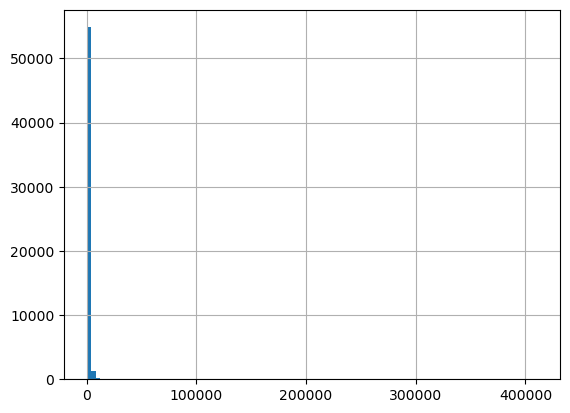

In [4]:
#because of above restrictions - most importantly token restriction (TPM), I need to check my dataset and maybe make some cutoffs.
quora_question_answer_dataset['question_len'] = quora_question_answer_dataset['question'].str.len()
quora_question_answer_dataset['answer_len'] = quora_question_answer_dataset['answer'].str.len()
print('max question len:', max(quora_question_answer_dataset['question_len']), '\nmax answer len:', max(quora_question_answer_dataset['answer_len']))
quora_question_answer_dataset['answer_len'].hist(bins=100)

<Axes: >

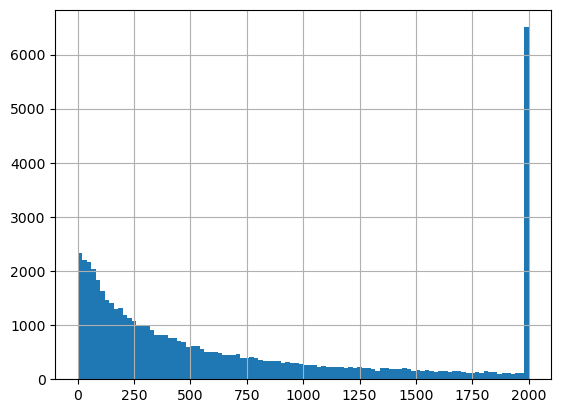

In [5]:
#impose a cutoff of tokens:
cutoff_tokens = 2000
quora_question_answer_dataset['answer_mod'] = quora_question_answer_dataset['answer'].str[:cutoff_tokens]
quora_question_answer_dataset['answer_mod_len'] = quora_question_answer_dataset['answer_mod'].str.len()
quora_question_answer_dataset['answer_mod_len'].hist(bins=100)

above plot shows that lots of data has more than this length but I impose this cutoff because openAI's API tier 1 has only so many tokens

In [6]:
# now, lets check what extremely short cases are
quora_question_answer_dataset.query('answer_mod_len < 5')['answer'].value_counts()

answer
No\n     89
Yes\n    81
No.\n    60
13\n     26
         19
         ..
Me\n      1
T\n       1
B\n       1
11\n      1
Dgg\n     1
Name: count, Length: 104, dtype: int64

Seems like they are mostly yes-no cases. I don't need them

In [7]:
#final clean:
quora_question_answer_dataset = quora_question_answer_dataset.query('answer_mod_len > 5').query('question_len > 5')
print(len(quora_question_answer_dataset))

55758


In [8]:
# convert questions and answers to list - easier to process this way for API purposes
questions = quora_question_answer_dataset['question'].tolist()
answers = quora_question_answer_dataset['answer_mod'].tolist()

In [32]:
#now, clean the questions and asnwers by removing redundat characters that might mess with parsing JSON:
questions = [remove_special_chars(quest) for quest in questions]
answers = [remove_special_chars(ans) for ans in answers]

In [9]:
dataset_size = len(quora_question_answer_dataset)

### translate with GPT-4o
prepare variables for translator API run:

In [ ]:
#read openAI key, because I'm going to use GPT-4o for translation.
#note: I wanted GOT-4o but it is not available in my free tier.
with open('api_keys/openAI_key.txt', 'r') as file:
    OPENAI_API_KEY = file.read().replace('\n', '')
client = OpenAI(api_key=OPENAI_API_KEY)

In [17]:
batch_size = 10

In [38]:
result = []
# I tried various batch sizes that would help with bypassing request limits
# also, batch size for request needed to be lowered because sometimes the return format was not matching json
# almost as if gpt-4o was forgetting to match required format. shorter batch size did not have same 'forgetting' effect
destination_file_name = 'data/quora_question_answer_dataset_geo.csv'
assert len(questions) == len(answers)

run the translator through API and save results on the way. Loop and sleep is used to bypass the token and request limitations.

In [62]:
%%time
for i in range(15, round(dataset_size/batch_size)+1):
    lower = i*batch_size
    upper = min((i+1)*batch_size, dataset_size)
    #making replacement to avoid json related errors
    questions_batch = [quest.replace('"', "'").replace("[", "<").replace("]", ">") for quest in questions[lower:upper]]
    answers_batch = [ans.replace('"', "'").replace("[", "<").replace("]", ">") for ans in answers[lower:upper]]
    question_answer_pair_list = {"questions": questions_batch, "answers": answers_batch}
    question_answer_pair_json = json.dumps(question_answer_pair_list)
    print('iteration', i, 'started.')
    translated = translate(client, question_answer_pair_json)
    
    # converting to JSON:
    try:
        tmp_df = pd.DataFrame.from_dict(json.loads(translated))
    except:
        print('problem converting to json.')
        print(translated)
        continue
    # write to .csv:
    if not os.path.isfile(destination_file_name):
        tmp_df.to_csv(destination_file_name, index=False)
    else:
        tmp_df.to_csv(destination_file_name, index=False, mode='a', header=False)
        
    print('iteration', i, 'ended.')
    result.append(translated)
    time.sleep(20)
    
print('data translation finished. items size in list:', len(result))

iteration 15 started.
iteration 15 ended.
iteration 16 started.
iteration 16 ended.
iteration 17 started.
iteration 17 ended.
iteration 18 started.
iteration 18 ended.
iteration 19 started.
problem converting to json.
{"questions": ["როგორც სახლში მყოფი მშობელი, რამდენად გეხმარებათ თქვენი პარტნიორი სახლის საქმეებში და ბავშვების მოვლაში?", "როგორ ახერხებენ ადამიანები, რომლებიც დღეში მხოლოდ ერთხელ ან ორჯერ ჭამენ, რომ არ იგრძნონ შიმშილი კვებებს შორის?", "არის თუ არა ორგანი საკმარისად მსგავსი პიანინოსთან, რომ პიანინოს დამკვრელმა, რომელიც ორგანს არ იცნობს, მარტივად გადაერთოს ორგანზე?", "რა სახლის დასუფთავების რჩევები გაქვთ მამაკაცებისთვის?", "რამდენი ხელფასი აქვთ CMA-ებს თვეში?", "შეგვიძლია თუ არა ჰაიზენბერგის გაურკვევლობის პრინციპის დამარცხება, თუ ერთი ადამიანი გაზომავს ნაწილაკის პოზიციას, ხოლო მეორე გაზომავს მის იმპულსს, მაგრამ ეს ორი ადამიანი არ ილაპარაკებს ერთმანეთთან და შედეგებს მესამე პირს გადასცემს?", "როგორც პოლიციელი, ყოფილა თუ არა შემთხვევა, რომ გამოძახებაზე მისვლისას თქვით საკუთა

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

### translate with  googletrans
As you can see from RateLimitError above, I dont have any more quota left for gpt so I'm going to try google translate.

In [51]:
#create translator object:
translator = Translator()
batch_size = 10

In [54]:
%%time
question_geo_googletrans_results = []
for i in range(0, round(dataset_size/batch_size)+1):
    lower = i*batch_size
    upper = min((i+1)*batch_size, dataset_size)
    question_geo_googletrans = [translator.translate(q, src='en', dest='georgian') 
                               for q in questions[lower:upper]]
    question_geo_googletrans_list = [q.text for q in question_geo_googletrans]
    question_geo_googletrans_results.append(question_geo_googletrans_list)
    print(i)
    time.sleep(30)
question_geo_googletrans_results

0
1
2
3
4
5
6
7
8
9
10
11
12


ConnectTimeout: _ssl.c:989: The handshake operation timed out

I very frequently got above message, or some permutation of connect/handshake error.  
Reason is too many requests or too many tokens.  
It shows that using free google translate service is not enough so I am going to switch to another approach using Google Cloud API.

### translate with Google Cloud API
By far this was most difficult API use I had to set up due to complex setup instructions that did not work.  
I could not authenticate with API key and had to create service account, then find how to make suitable JSON format for authentication.  
stackoverflow helped:
1) https://stackoverflow.com/questions/46287267/how-can-i-get-the-file-service-account-json-for-google-translate-api
2) https://stackoverflow.com/questions/51554341/google-auth-exceptions-defaultcredentialserror

In [10]:
credential_path = "api_keys/google_api_service_account.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
PARENT = f"projects/nlp-georgian-text-embeddings"

In [11]:
google_client = translate.TranslationServiceClient()
google_client

In [12]:
def translate_google_api(text):
    response = google_client.translate_text(parent=PARENT,
                                            contents=[text],
                                            target_language_code='ka',
                                            source_language_code='en',
                                            )
    return unescape(response.translations[0].translated_text)

In [35]:
google_api_destination_file_name = 'datasets/quora_questions_geo_google_api.csv'

In [36]:
%%time
questions_translated_google_api = []
#batch_size = 10

for i in range(0, dataset_size):
    #making replacement to avoid json related errors
    translated = translate_google_api(questions[i])
    questions_translated_google_api.append(translated)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [44]:
%%time
answers_translated_google_api = []

for i in range(0, dataset_size):
    #making replacement to avoid json related errors
    translated = translate_google_api(answers[i])
    answers_translated_google_api.append(translated)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

DeadlineExceeded: 504 Deadline Exceeded

even 300 usd was not enough to parse all the trimmed answers. I'm going to save whatever I have and replace others with blanks.

In [50]:
blanks_cnt = len(quora_question_answer_dataset)-len(answers_translated_google_api)
answers_translated_google_api_copy = answers_translated_google_api+['blank' for i in range(blanks_cnt)]
len(answers_translated_google_api_copy), len(quora_question_answer_dataset)
answers_translated_google_api_copy

['საშინელება არაა? დაიფიცებდი, რომ არ იყო საკმარისი ცხელი წყალი გარშემო!',
 'პროქსი სერვერი არის სისტემა ან როუტერი, რომელიც უზრუნველყოფს კარიბჭეს მომხმარებლებსა და ინტერნეტს შორის. აქედან გამომდინარე, ის ხელს უწყობს კიბერ თავდამსხმელების კერძო ქსელში შესვლის თავიდან აცილებას. ეს არის სერვერი, რომელსაც მოიხსენიებენ, როგორც „შუამავალს“, რადგან ის მიდის საბოლოო მომხმარებლებსა და ვებ გვერდებს შორის, რომლებსაც ისინი ონლაინ სტუმრობენ. როდესაც კომპიუტერი უერთდება ინტერნეტს, ის იყენებს IP მისამართს. ეს თქვენი სახლის ქუჩის მისამართის მსგავსია, შემომავალ მონაცემებს ეუბნება, სად უნდა წავიდეს და გამავალი მონაცემების მონიშვნა დაბრუნების მისამართით სხვა მოწყობილობებისთვის ავთენტიფიკაციისთვის. პროქსი სერვერი არსებითად არის კომპიუტერი ინტერნეტში, რომელსაც აქვს საკუთარი IP მისამართი. როგორ მუშაობს პროქსი იმიტომ, რომ პროქსი სერვერს აქვს საკუთარი IP მისამართი, ის მოქმედებს როგორც შუამავალი კომპიუტერისა და ინტერნეტისთვის. თქვენმა კომპიუტერმა იცის ეს მისამართი და როდესაც თქვენ აგზავნით მოთხოვნას ინტერნეტშ

save to file:

In [52]:
quora_question_answer_dataset['questions_google_api_geo'] = questions_translated_google_api
quora_question_answer_dataset['answers_google_api_geo'] = answers_translated_google_api_copy
quora_question_answer_dataset.to_csv('datasets/quora_question_answer_dataset_google_api_geo.csv', index=False)